## This notebook is for Linear stability analysis of the circuit, and uses the search result from parameter search in the preliminary analysis. In the previous one, $b_i$, $V_i$, $\mu_i$, $K_{Ai}$, $K_{Bi}$ and $K_{Ci}$ are taken the same. 

![Circute 3954](3954.png "Circute 3954")

## Here, we extend the search by starting from these points.

In [1]:
%config Completer.use_jedi = False
from sympy import *
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Latex

from tqdm import tqdm

import sys
sys.path.append("/end/home/rh2310/morpho_repo/amplitude_method")
from utils import *

from scipy.optimize import fsolve
from scipy.linalg import eigvals

In [2]:
init_printing(use_latex='mathjax')#(use_latex=True)

#### Define a list of parameters

In [3]:
A, B, C = symbols('A, B, C', real=True, positive = True)

D_A, D_B = symbols('D_A, D_B', real=True, positive = True)

(b_A, b_B, b_C,
 V_A, V_B, V_C,
K_AA, K_AB, K_AC, K_BA, K_BC, K_CB, K_CC,
μ_A, μ_B, μ_C) = symbols(
    'b_A, b_B, b_C, V_A, V_B, V_C, K_AA, K_AB, K_AC, K_BA, K_BC, K_CB, K_CC, mu_A, mu_B, mu_C', 
    real=True, positive = True)

k, n = symbols('k, n', integer=True)

> The PDEs are as follows

<h3><center>$
     \frac{\partial A}{\partial t} = b_A  +   V_A  \frac{1}{1+\left(\frac{K_{AA}}{A }\right)^{n}} \frac{1}{1+\left(\frac{B}{K_{BA} }\right)^{n}} -  \mu_A A + D_A \nabla^2 A,
$</center></h3>

<h3><center>$     \frac{\partial B}{\partial t} = b_B  +   V_B  \frac{1}{1+\left(\frac{K_{AB}}{A }\right)^{n}} \frac{1}{1+\left(\frac{C}{K_{CB} }\right)^{n}} -  \mu_B B + D_B \nabla^2 B,
$</center></h3>

<h3><center>$
\frac{\partial C}{\partial t} = b_C  +   V_C  \frac{1}{1+\left(\frac{A}{K_{AC} }\right)^{n}} \frac{1}{1+\left(\frac{B}{K_{BC} }\right)^{n}} \frac{1}{1+\left(\frac{K_{CC}}{C }\right)^{n}} -  \mu_C C,
$</center></h3>

![Circute 3954](3954.png "Circute 3954")

Then, we define kinetic terms as

<h3><center>$f_A(A, B, C) = b_A  +   V_A  \frac{1}{1+\left(\frac{K_{AA}}{A }\right)^{n}} \frac{1}{1+\left(\frac{B}{K_{BA} }\right)^{n}} -  \mu_A A$</center></h3>
<h3><center>$f_B(A, B, C) = b_B  +   V_B  \frac{1}{1+\left(\frac{K_{AB}}{A }\right)^{n}} \frac{1}{1+\left(\frac{C}{K_{CB} }\right)^{n}} -  \mu_B B$</center></h3>
<h3><center>$f_C(A, B, C) = b_C  +   V_C  \frac{1}{1+\left(\frac{A}{K_{AC} }\right)^{n}} \frac{1}{1+\left(\frac{B}{K_{BC} }\right)^{n}} \frac{1}{1+\left(\frac{K_{CC}}{C }\right)^{n}} -  \mu_C C$</center></h3>


In [4]:
def act(x, K, n):
    return 1/(1 + (K/x)**n)

def inh(x, K, n):
    return 1/(1 + (x/K)**n)


fA = b_A + V_A*act(A, K_AA, n)*inh(B, K_BA, n) - μ_A * A
fB = b_B + V_B*act(A, K_AB, n)*inh(C, K_CB, n) - μ_B * B
fC = b_C + V_C*inh(A, K_AC, n)*inh(B, K_BC, n)*act(C, K_CC, n) - μ_C * C

lprint(r"$f_A(A, B, C) =$ {0}", fA)
lprint(r"$f_B(A, B, C) =$ {0}", fB)
lprint(r"$f_C(A, B, C) =$ {0}", fC)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

#### which as a vector, we can define it like

In [5]:
Kinetic = Matrix([[fA], [fB], [fC]])
lprint(r"$\boldsymbol{f}(A, B, C) =$ {0} ", Kinetic)

<IPython.core.display.Latex object>

#### First, we find the fix points of the system without diffusion. 


The solution of the above system finds $A^*, B^*, C^*$ such that
<center>$f_A(A^*, B^*, C^*) = 0$</center>
<center>$f_B(A^*, B^*, C^*) = 0$</center>
<center>$f_C(A^*, B^*, C^*) = 0$</center>

In [6]:
f1 = lambdify([n, b_A, μ_A, V_A, K_AA, K_AB, K_AC,
               b_B, μ_B, V_B, K_BA, K_BC,
               b_C, μ_C, V_C, K_CB, K_CC,
               A,B,C], 
               fA,
              modules='numpy')

f2 = lambdify([n, b_A, μ_A, V_A, K_AA, K_AB, K_AC,
               b_B, μ_B, V_B, K_BA, K_BC,
               b_C, μ_C, V_C, K_CB, K_CC,
               A,B,C], 
              fB,
              modules='numpy')

f3 = lambdify([n, b_A, μ_A, V_A, K_AA, K_AB, K_AC,
               b_B, μ_B, V_B, K_BA, K_BC,
               b_C, μ_C, V_C, K_CB, K_CC,
               A,B,C], 
               fC,
              modules='numpy')

def create_func(n, b_A, μ_A, V_A, K_AA, K_AB, K_AC,
               b_B, μ_B, V_B, K_BA, K_BC,
               b_C, μ_C, V_C, K_CB, K_CC):
    def f_1(args):
        A,B,C = args
        return (f1(n, b_A, μ_A, V_A, K_AA, K_AB, K_AC,
                   b_B, μ_B, V_B, K_BA, K_BC,
                   b_C, μ_C, V_C, K_CB, K_CC, A,B,C),
                f2(n, b_A, μ_A, V_A, K_AA, K_AB, K_AC,
                   b_B, μ_B, V_B, K_BA, K_BC,
                   b_C, μ_C, V_C, K_CB, K_CC, A,B,C),
                f3(n, b_A, μ_A, V_A, K_AA, K_AB, K_AC,
                   b_B, μ_B, V_B, K_BA, K_BC,
                   b_C, μ_C, V_C, K_CB, K_CC, A,B,C)) 
    
    return f_1

#### Next, to linearise the PDE system, we find the Jacobian of $(f_A, f_B, f_C)$ 

In [7]:
J_jac = Kinetic.jacobian([A, B, C])
hprint(r"J= \frac{\partial \boldsymbol{f}_i}{\partial u_j} = ", J_jac)
J_jac_func = lambdify([n, b_A, μ_A, V_A, K_AA, K_AB, K_AC,
                       b_B, μ_B, V_B, K_BA, K_BC,
                       b_C, μ_C, V_C, K_CB, K_CC, A,B,C], 
                       J_jac,
              modules='numpy')

<IPython.core.display.Latex object>

## Including the diffusion

In [8]:
J_jac_diff = J_jac - Matrix([[D_A*k**2, 0,        0], 
                             [0,        D_B*k**2, 0],
                             [0,        0,        0],
                           ])
hprint(r"J_{diff}= ", J_jac_diff)

J_jac_diff_func = lambdify([n, b_A, μ_A, V_A, K_AA, K_AB, K_AC,
                            b_B, μ_B, V_B, K_BA, K_BC,
                            b_C, μ_C, V_C, K_CB, K_CC, A,B,C], 
               J_jac_diff,
              modules='numpy')

<IPython.core.display.Latex object>

In [13]:
from itertools import product
#list(product([1,-1], repeat=3))
def find_roots(n_val, 
               b_A_val, mu_A_val, V_A_val, K_AA_val, K_AB_val, K_AC_val,
               b_B_val, mu_B_val, V_B_val, K_BA_val, K_BC_val,
               b_C_val, mu_C_val, V_C_val, K_CB_val, K_CC_val):    
    func = create_func(n_val, 
                       b_A_val, mu_A_val, V_A_val, K_AA_val, K_AB_val, K_AC_val,
                       b_B_val, mu_B_val, V_B_val, K_BA_val, K_BC_val,
                       b_C_val, mu_C_val, V_C_val, K_CB_val, K_CC_val)
    #
    roots_res = []
    for init_vals in product([.1,-.1], repeat=3):        
        roots, d, ier, msg = fsolve(func, init_vals, xtol=1e-7, maxfev=10000,  full_output=1)
        (a_1, b_1, c_1) = func(roots)
        if ier == 1 and a_1 < 1e-7 and b_1 < 1e-7 and c_1 < 1e-7:
            roots_res.append(roots)
    for init_vals in product([1,-1], repeat=3):        
        roots, d, ier, msg = fsolve(func, init_vals, xtol=1e-7, maxfev=10000,  full_output=1)
        (a_1, b_1, c_1) = func(roots)
        if ier == 1 and a_1 < 1e-7 and b_1 < 1e-7 and c_1 < 1e-7:
            roots_res.append(roots)
        
    for init_vals in product([10,-10], repeat=3):        
        roots, d, ier, msg = fsolve(func, init_vals, xtol=1e-7, maxfev=10000,  full_output=1)
        (a_1, b_1, c_1) = func(roots)
        if ier == 1 and a_1 < 1e-7 and b_1 < 1e-7 and c_1 < 1e-7:
            roots_res.append(roots)
    
    for init_vals in product([100,-100], repeat=3):        
        roots, d, ier, msg = fsolve(func, init_vals, xtol=1e-7, maxfev=10000,  full_output=1)
        (a_1, b_1, c_1) = func(roots)
        if ier == 1 and a_1 < 1e-7 and b_1 < 1e-7 and c_1 < 1e-7:
            roots_res.append(roots)
     
    if len(roots_res) == 0:
        print(msg)
        print(roots)
        print(a_1, b_1, c_1)
        return roots_res 
    else:
        roots_res2 = [roots_res[0]]
        for item in roots_res[1:]:
            if np.any(item < 0):
                continue
            if not np.any([np.isclose(item2, item) for item2 in roots_res2]):
                roots_res2.append(item)
        return roots_res2
        
    

def find_root_original(n_val, 
               b_A_val, mu_A_val, V_A_val, K_AA_val, K_AB_val, K_AC_val,
               b_B_val, mu_B_val, V_B_val, K_BA_val, K_BC_val,
               b_C_val, mu_C_val, V_C_val, K_CB_val, K_CC_val):    
    func = create_func(n_val, 
                       b_A_val, mu_A_val, V_A_val, K_AA_val, K_AB_val, K_AC_val,
                       b_B_val, mu_B_val, V_B_val, K_BA_val, K_BC_val,
                       b_C_val, mu_C_val, V_C_val, K_CB_val, K_CC_val)        
    roots, d, ier, msg = fsolve(func, [10, 10, 10], xtol=1e-10, maxfev=100000,  full_output=1)        
    # check the solution is valid
    (a_1, b_1, c_1) = func(roots)
    if ier != 1 or a_1 > 1e-8 or b_1 > 1e-8 or c_1 > 1e-8 :
        roots, d, ier, msg = fsolve(func, [-1, -1, -1], xtol=1e-10, maxfev=100000,  full_output=1)
        # check the solution is valid
        (a_1, b_1, c_1) = func(roots)
        if ier != 1 or a_1 > 1e-8 or b_1 > 1e-8 or c_1 > 1e-8 :
            print("================================================")
            print(f"     roots original finds failed.")
            print("================================================")
    return roots

def get_dispersions(ks, 
                    n_val, D_A_val, D_B_val,
                    b_A_val, mu_A_val, V_A_val, K_AA_val, K_AB_val, K_AC_val,
                    b_B_val, mu_B_val, V_B_val, K_BA_val, K_BC_val,
                    b_C_val, mu_C_val, V_C_val, K_CB_val, K_CC_val,
                    A_star, B_star, C_star):    
    λ_1, λ_2, λ_3 = list(J_jac_diff.subs(
                          {n:n_val, 
                           b_A:b_A_val, 
                           μ_A:mu_A_val, 
                           V_A:V_A_val,
                           K_AA:K_AA_val, 
                           K_AB:K_AB_val,  
                           K_AC:K_AC_val,
                           b_B:b_B_val, 
                           μ_B:mu_B_val, 
                           V_B:V_B_val,
                           K_BA:K_BA_val, 
                           K_BC:K_BC_val,  
                           b_C:b_C_val, 
                           μ_C:mu_C_val, 
                           V_C:V_C_val,
                           K_CB:K_CB_val, 
                           K_CC:K_CC_val,  
                           A:A_star, 
                           B:B_star, 
                           C:C_star}
                     ).eigenvals().keys())
    
    λ_1_func = lambdify([k, D_A, D_B], 
                         λ_1,
                         modules='numpy')
    λ_2_func = lambdify([k, D_A, D_B], 
                         λ_2,
                         modules='numpy')
    λ_3_func = lambdify([k, D_A, D_B], 
                         λ_3,
                         modules='numpy')
    
    def check_type(item):
        return not isinstance(item, float) and not isinstance(item, int)
    
    dis1 = λ_1_func(ks, D_A_val, D_B_val)
    dis2 = λ_2_func(ks, D_A_val, D_B_val)    
    dis3 = λ_3_func(ks, D_A_val, D_B_val)   
    return dis1, dis2,dis3



In [10]:
with open('turing_parameters.npy', 'rb') as f:
    turing_parameters = np.load(f)

with open('./outputs/indices.npy', 'rb') as f:
    indices = np.load(f)

In [16]:
def plot_dispersion(index):
    print("=============================================")
    print(index+1,":" ,indices[index])
    with open(f"./outputs/parameters_100_{indices[index]}.npy", "rb") as f:
            params = np.load(f)
    (n_val_org, 
     b_A_val_org, mu_A_val_org, V_A_val_org, K_AA_val_org, K_AB_val_org, K_AC_val_org,
     b_B_val_org, mu_B_val_org, V_B_val_org, K_BA_val_org, K_BC_val_org,
     b_C_val_org, mu_C_val_org, V_C_val_org, K_CB_val_org, K_CC_val_org) = params
    
    with open(f"./PINN_outputs/parameters_{indices[index]}.npy", "rb") as f:
        if index < 11:
            (n_val, D_A_val, D_B_val,
                b_A_val, b_B_val, b_C_val, V_A_val, V_B_val, V_C_val, mu_A_val, mu_B_val, mu_C_val,
                K_AA_val, K_AB_val, K_AC_val, K_BA_val, K_BC_val, 
                K_CB_val, K_CC_val) = np.load(f)
        else:
            (_, n_val, D_A_val, D_B_val,
                b_A_val, b_B_val, b_C_val, V_A_val, V_B_val, V_C_val, mu_A_val, mu_B_val, mu_C_val,
                K_AA_val, K_AB_val, K_AC_val, K_BA_val, K_BC_val, 
                K_CB_val, K_CC_val) = np.load(f)
        
    print("Original params")
    print(f"b_A:{b_A_val_org:.3f}, V_A:{V_A_val_org:.3f}, K_AA:{K_AA_val_org:.3f}, K_AB:{K_AB_val_org:.3f}, K_AC:{K_AC_val_org:.3f}\n"
          f"b_B:{b_B_val_org:.3f}, V_B:{V_B_val_org:.3f}, K_BA:{K_BA_val_org:.3f}, K_BC:{K_BC_val_org:.3f}\n"
          f"b_C:{b_C_val_org:.3f}, V_C:{V_C_val_org:.3f}, K_CB:{K_CB_val_org:.3f}, K_CC:{K_CC_val_org:.3f}"
         )
    print("Estimated")
    print(f"b_A:{b_A_val:.3f}, V_A:{V_A_val:.3f}, K_AA:{K_AA_val:.3f}, K_AB:{K_AB_val:.3f}, K_AC:{K_AC_val:.3f}\n"
          f"b_B:{b_B_val:.3f}, V_B:{V_B_val:.3f}, K_BA:{K_BA_val:.3f}, K_BC:{K_BC_val:.3f}\n"
          f"b_C:{b_C_val:.3f}, V_C:{V_C_val:.3f}, K_CB:{K_CB_val:.3f}, K_CC:{K_CC_val:.3f}\n"
         )
    ##########################################################
    ks = np.linspace(0.001, 20, 500).astype(np.complex128)
    A_star_org, B_star_org, C_star_org = find_root_original(n_val_org, 
                             b_A_val_org, mu_A_val_org, V_A_val_org, K_AA_val_org, K_AB_val_org, K_AC_val_org,
                             b_B_val_org, mu_B_val_org, V_B_val_org, K_BA_val_org, K_BC_val_org,
                             b_C_val_org, mu_C_val, V_C_val_org, K_CB_val_org, K_CC_val_org)
    
    
    dis1_org, dis2_org, dis3_org =get_dispersions(ks, n_val_org, D_A_val, D_B_val,
                                    b_A_val_org, mu_A_val_org, V_A_val_org, K_AA_val_org, K_AB_val_org, K_AC_val_org,
                                    b_B_val_org, mu_B_val_org, V_B_val_org, K_BA_val_org, K_BC_val_org,
                                    b_C_val_org, mu_C_val_org, V_C_val_org, K_CB_val_org, K_CC_val_org,
                                    A_star_org, B_star_org, C_star_org)
    
    roots_res = find_roots(n_val, 
                         b_A_val, mu_A_val, V_A_val, K_AA_val, K_AB_val, K_AC_val,
                         b_B_val, mu_B_val, V_B_val, K_BA_val, K_BC_val,
                         b_C_val, mu_C_val, V_C_val, K_CB_val, K_CC_val)
    if len(roots_res) == 0:
        raise Exception("No roots")
    elif len(roots_res) > 1:
        print("More than one root")
        #for item in roots_res:
        #    print(item)
    for A_star, B_star, C_star in roots_res:
        print(A_star_org, B_star_org, C_star_org )
        print(A_star, B_star, C_star)
        dis1, dis2, dis3=get_dispersions(ks, n_val, D_A_val, D_B_val,
                                    b_A_val, mu_A_val, V_A_val, K_AA_val, K_AB_val, K_AC_val,
                                    b_B_val, mu_B_val, V_B_val, K_BA_val, K_BC_val,
                                    b_C_val, mu_C_val, V_C_val, K_CB_val, K_CC_val,
                                        A_star, B_star, C_star)
    
        #######################################################
        plt.figure(figsize=(14,5))
        plt.subplot(131)
        plt.title(f"Dispersion one - {np.any(np.real(dis1) > 0)}")
        plt.plot(ks, np.real(dis1_org), label="original-Real")
        plt.plot(ks, np.imag(dis1_org), label="original-Imaginary")
        plt.plot(ks, np.real(dis1), '--' , label="estimate-Real")
        plt.plot(ks, np.imag(dis1), '--', label="estimate-Imaginary")
        plt.grid();plt.legend()
        plt.subplot(132)
        plt.title(f"Dispersion two - {np.any(np.real(dis2) > 0)}")
        plt.plot(ks, np.real(dis2_org), label="original-Real")
        plt.plot(ks, np.imag(dis2_org), label="original-Imaginary")
        plt.plot(ks, np.real(dis2), '--' , label="estimate-Real")
        plt.plot(ks, np.imag(dis2), '--', label="estimate-Imaginary")
        plt.grid();plt.legend()
        plt.subplot(133)
        plt.title(f"Dispersion three - {np.any(np.real(dis3) > 0)}")
        plt.plot(ks, np.real(dis3_org), label="original-Real")
        plt.plot(ks, np.imag(dis3_org), label="original-Imaginary")
        plt.plot(ks, np.real(dis3), '--' , label="estimate-Real")
        plt.plot(ks, np.imag(dis3), '--', label="estimate-Imaginary")
        plt.grid();plt.legend()
        plt.tight_layout();plt.show()
   
        
        

1 : 6685
Original params
b_A:1.000, V_A:5.000, K_AA:5.000, K_AB:5.000, K_AC:10.000
b_B:1.000, V_B:5.000, K_BA:5.000, K_BC:5.000
b_C:1.000, V_C:100.000, K_CB:10.000, K_CC:50.000
Estimated
b_A:1.017, V_A:4.341, K_AA:4.988, K_AB:7.234, K_AC:1.588
b_B:1.179, V_B:11.189, K_BA:5.516, K_BC:0.215
b_C:1.000, V_C:89.449, K_CB:72.518, K_CC:2.614

2.8674820117826236 2.9745853991155187 2.0004523566930286
2.587027335911821 2.718123612890818 2.0005412825699302


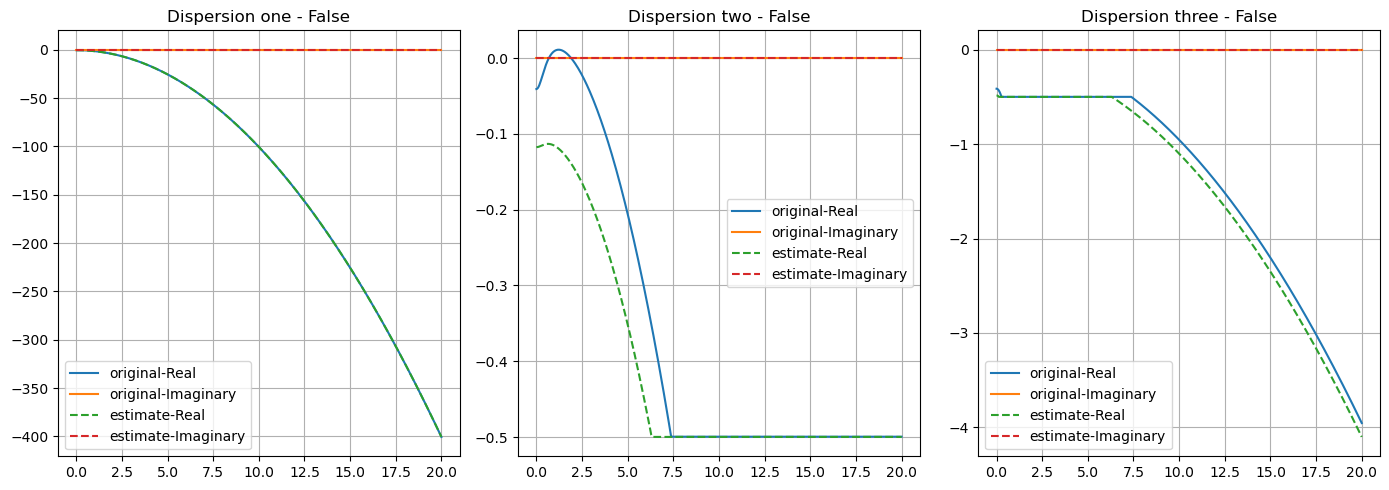

2 : 3464
Original params
b_A:0.001, V_A:5.000, K_AA:0.001, K_AB:0.001, K_AC:5.000
b_B:0.001, V_B:5.000, K_BA:0.100, K_BC:5.000
b_C:0.100, V_C:25.000, K_CB:25.000, K_CC:25.000
Estimated
b_A:0.005, V_A:15.000, K_AA:2.070, K_AB:0.002, K_AC:1.935
b_B:0.505, V_B:23.506, K_BA:0.991, K_BC:0.002
b_C:0.100, V_C:89.566, K_CB:85.580, K_CC:2.426

0.0009995598975088848 0.4997585185941462 1.0006415783410563
0.0010029451923206894 0.36573854589847676 1.0006422681868559


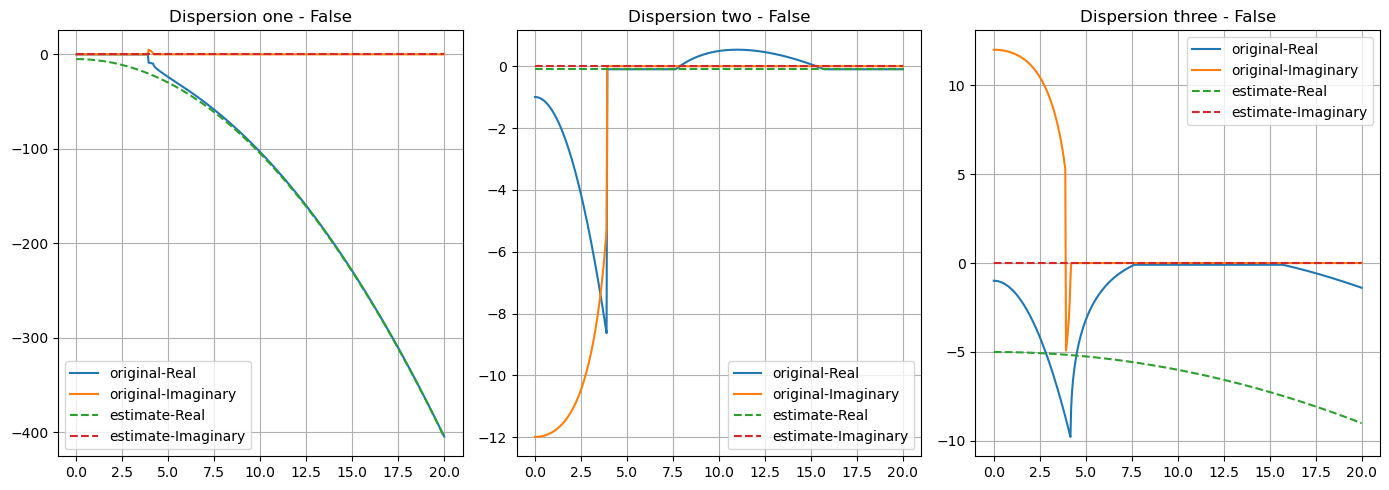

3 : 1232
Original params
b_A:0.001, V_A:10.000, K_AA:0.500, K_AB:0.500, K_AC:5.000
b_B:0.100, V_B:25.000, K_BA:5.000, K_BC:20.000
b_C:0.500, V_C:50.000, K_CB:50.000, K_CC:10.000
Estimated
b_A:0.002, V_A:18.396, K_AA:0.504, K_AB:0.500, K_AC:0.915
b_B:0.101, V_B:25.000, K_BA:4.273, K_BC:0.859
b_C:0.500, V_C:89.391, K_CB:85.942, K_CC:2.309

0.4522594085303392 10.124348298639681 0.5002939121219597
0.4518617351798064 10.102920157686569 0.5003062836485682


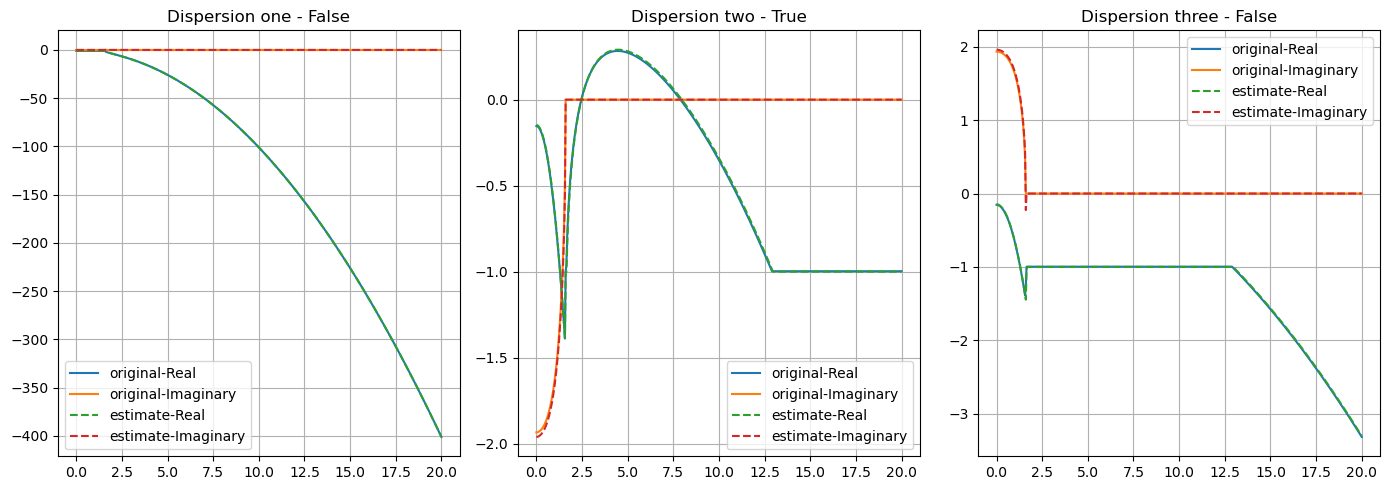

4 : 1900
Original params
b_A:0.001, V_A:25.000, K_AA:0.500, K_AB:0.500, K_AC:5.000
b_B:0.001, V_B:25.000, K_BA:10.000, K_BC:5.000
b_C:1.000, V_C:5.000, K_CB:5.000, K_CC:25.000
Estimated
b_A:0.002, V_A:24.249, K_AA:0.502, K_AB:0.500, K_AC:1.241
b_B:0.003, V_B:24.375, K_BA:10.082, K_BC:0.324
b_C:1.000, V_C:89.490, K_CB:84.388, K_CC:2.539

More than one root
0.5254077777677558 26.78655705959283 2.0000004965639273
0.003263430635254917 0.006224572459913503 180.97976531713854


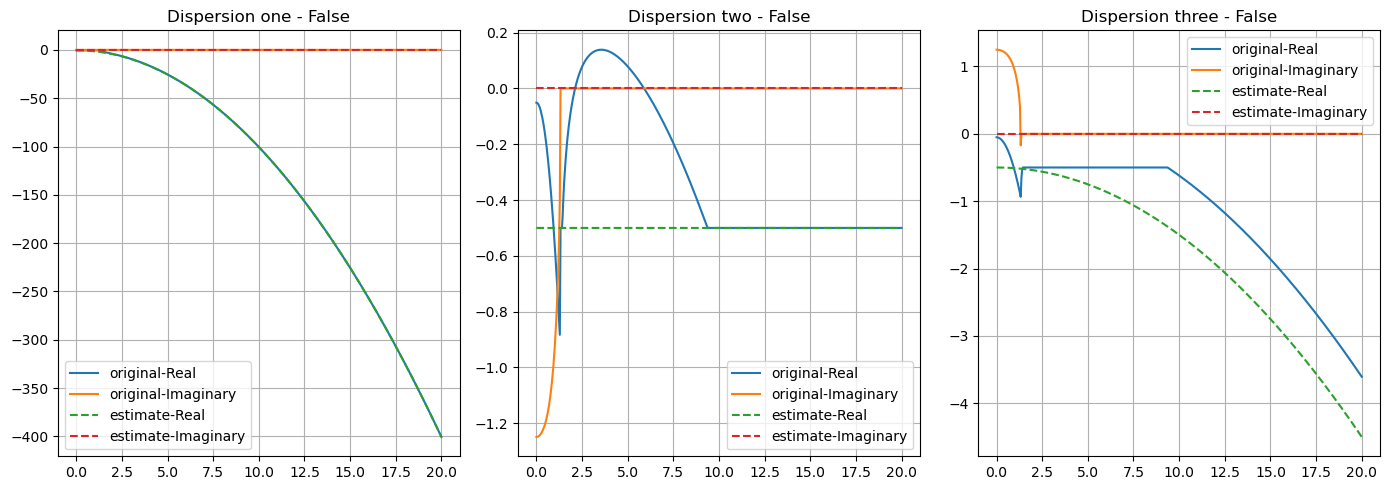

0.5254077777677558 26.78655705959283 2.0000004965639273
0.5251062673668343 26.758849726731142 2.0000002066371


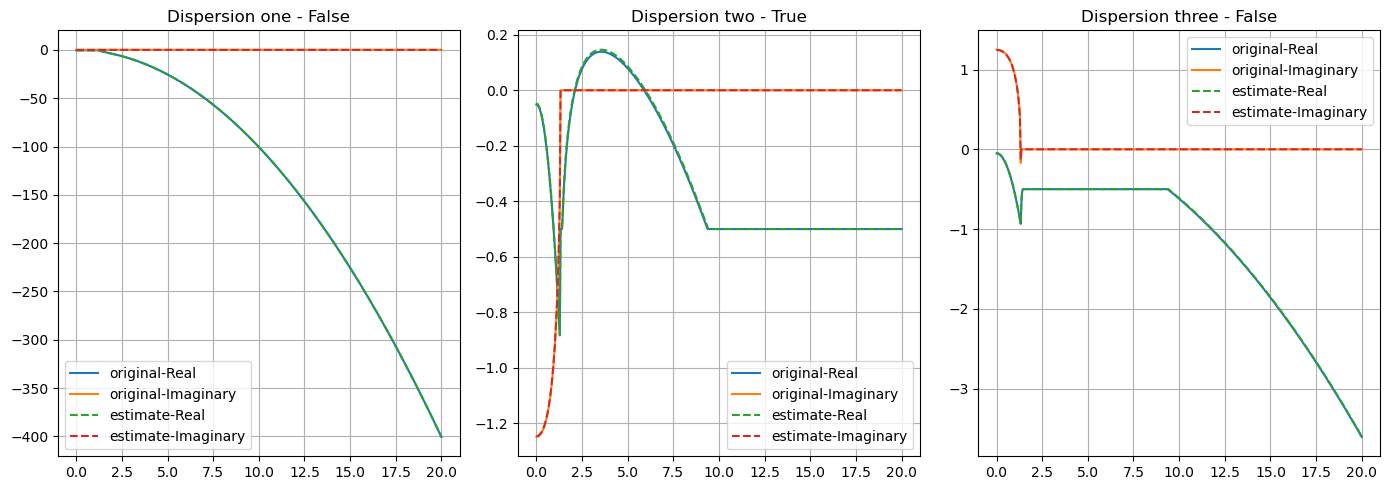

5 : 2131
Original params
b_A:0.001, V_A:25.000, K_AA:5.000, K_AB:5.000, K_AC:5.000
b_B:0.500, V_B:50.000, K_BA:20.000, K_BC:5.000
b_C:1.000, V_C:5.000, K_CB:100.000, K_CC:100.000
Estimated
b_A:0.008, V_A:32.274, K_AA:5.048, K_AB:4.967, K_AC:1.442
b_B:0.560, V_B:49.559, K_BA:18.552, K_BC:0.233
b_C:1.000, V_C:89.502, K_CB:109.633, K_CC:2.531

More than one root
5.342912682687607 28.797325382439823 2.0000000006305796
0.01668399038675461 0.5600390497357729 7.08857087279401


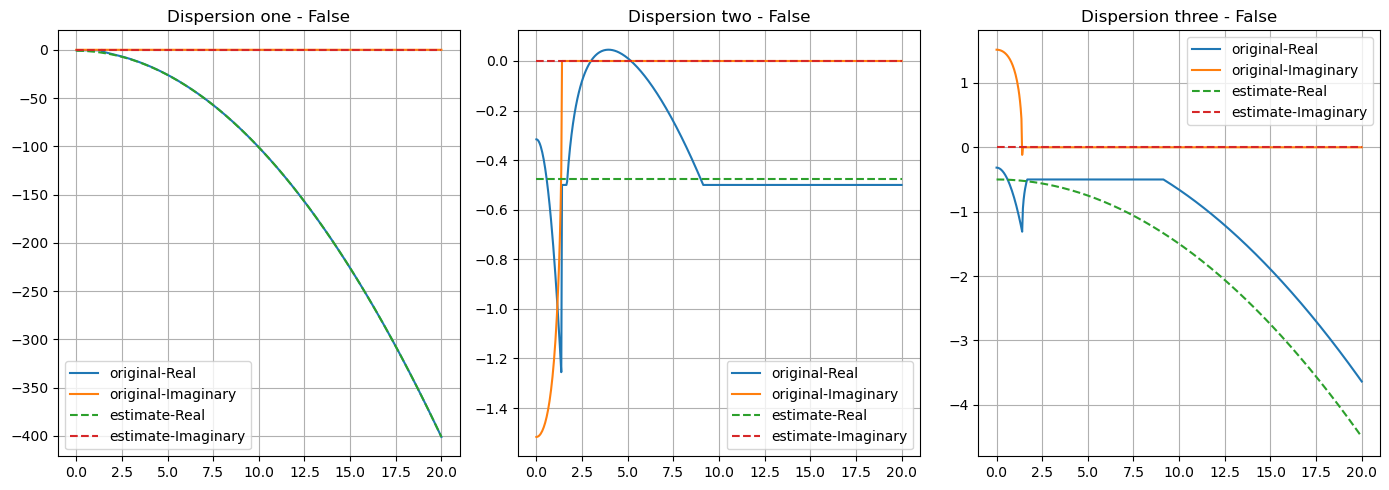

5.342912682687607 28.797325382439823 2.0000000006305796
2.178017697817461 2.3271491171108103 2.00079656833476


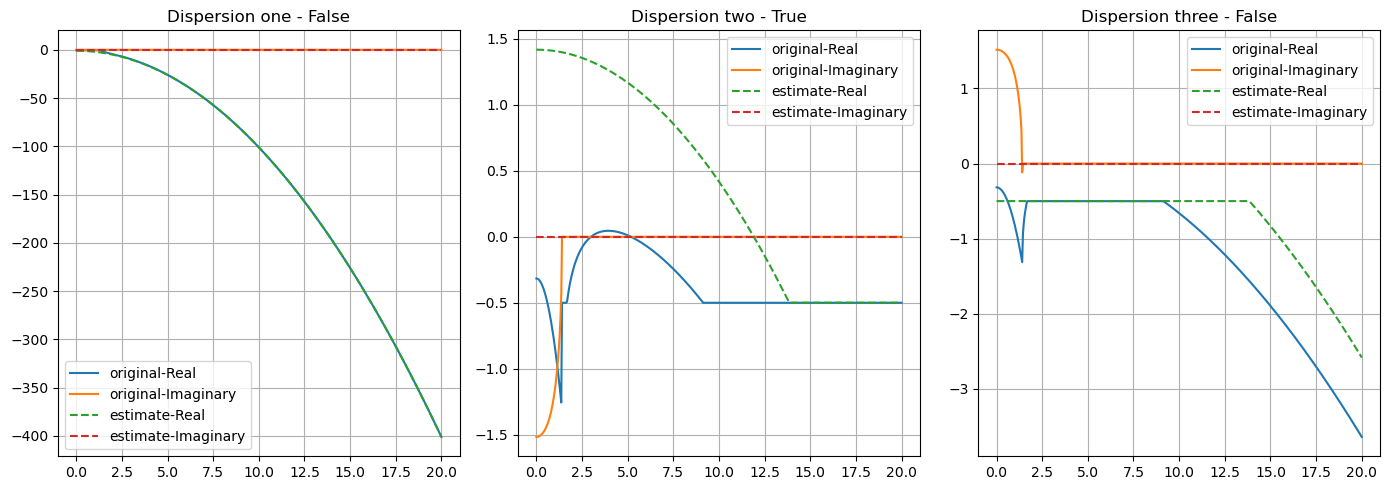

5.342912682687607 28.797325382439823 2.0000000006305796
5.3163530416035565 28.688789586072037 1.9999885570754692


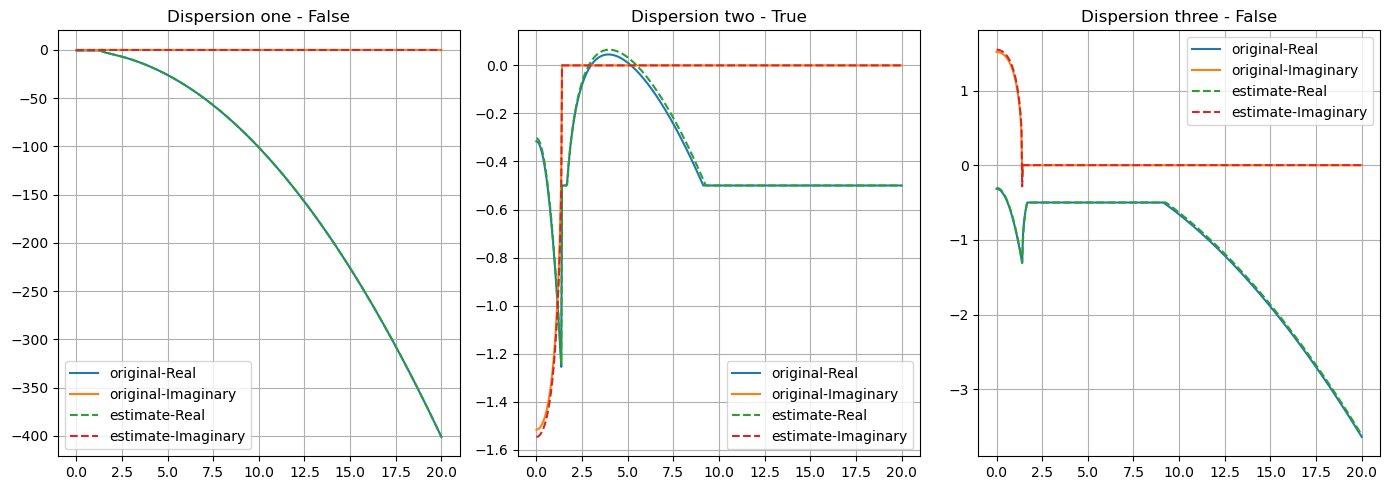

6 : 5015
Original params
b_A:0.100, V_A:25.000, K_AA:1.000, K_AB:0.500, K_AC:0.500
b_B:0.100, V_B:25.000, K_BA:5.000, K_BC:0.500
b_C:0.100, V_C:50.000, K_CB:10.000, K_CC:10.000
Estimated
b_A:0.101, V_A:18.611, K_AA:1.005, K_AB:0.500, K_AC:1.231
b_B:0.096, V_B:24.999, K_BA:5.402, K_BC:0.103
b_C:0.100, V_C:89.517, K_CB:89.786, K_CC:2.604

0.4048859250090544 7.6172675373863115 0.10000000000649105
0.40211262362200634 7.471051176341369 0.10000000149718209


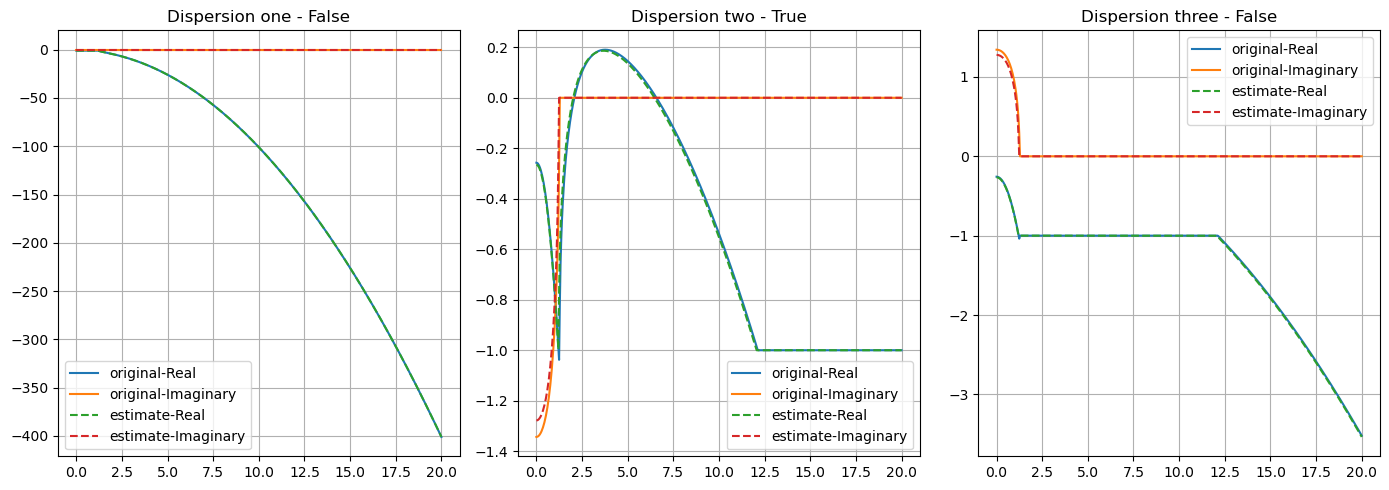

7 : 2253
Original params
b_A:0.001, V_A:25.000, K_AA:5.000, K_AB:5.000, K_AC:5.000
b_B:0.100, V_B:50.000, K_BA:20.000, K_BC:5.000
b_C:1.000, V_C:10.000, K_CB:100.000, K_CC:5.000
Estimated
b_A:0.017, V_A:32.561, K_AA:5.013, K_AB:4.967, K_AC:4.940
b_B:0.178, V_B:49.528, K_BA:18.441, K_BC:1.266
b_C:1.000, V_C:89.745, K_CB:109.627, K_CC:1.686

5.3932757836032765 28.8570732632871 2.00019106346114
5.371416992421786 28.786032850867876 2.000198905991578


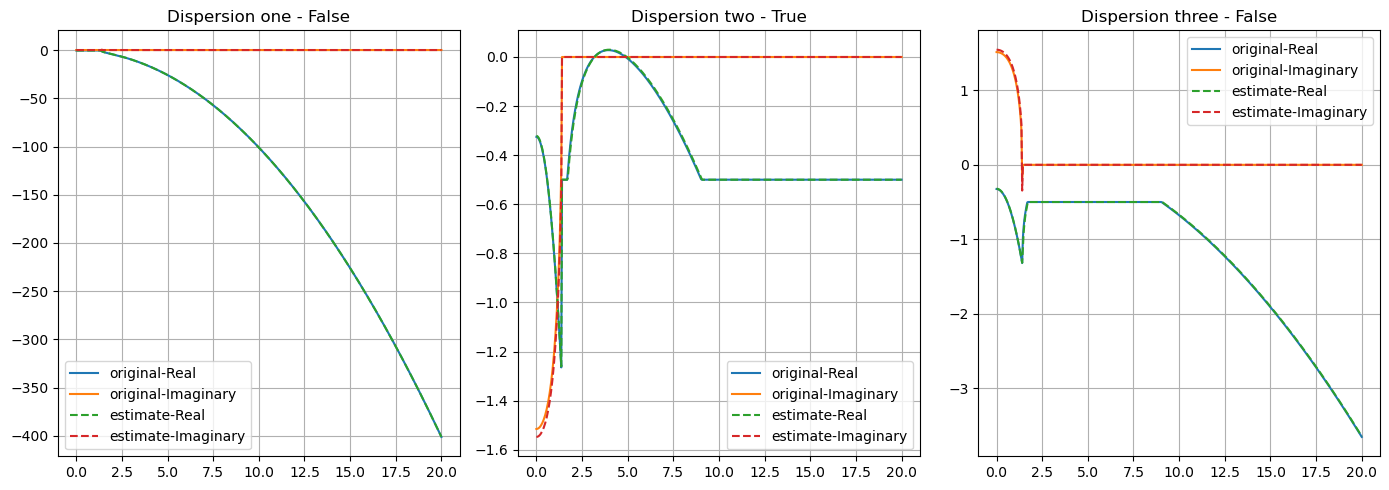

8 : 7158
Original params
b_A:1.000, V_A:100.000, K_AA:1.000, K_AB:0.500, K_AC:0.500
b_B:5.000, V_B:25.000, K_BA:0.500, K_BC:0.500
b_C:10.000, V_C:50.000, K_CB:25.000, K_CC:100.000
Estimated
b_A:0.991, V_A:21.914, K_AA:0.940, K_AB:0.500, K_AC:18.781
b_B:5.028, V_B:24.976, K_BA:0.791, K_BC:11.631
b_C:3.613, V_C:91.530, K_CB:89.321, K_CC:0.382

0.45834346221895544 0.6138779020575236 0.20000000000286594
0.20889684987621052 0.23054580988175424 0.07497774941710864


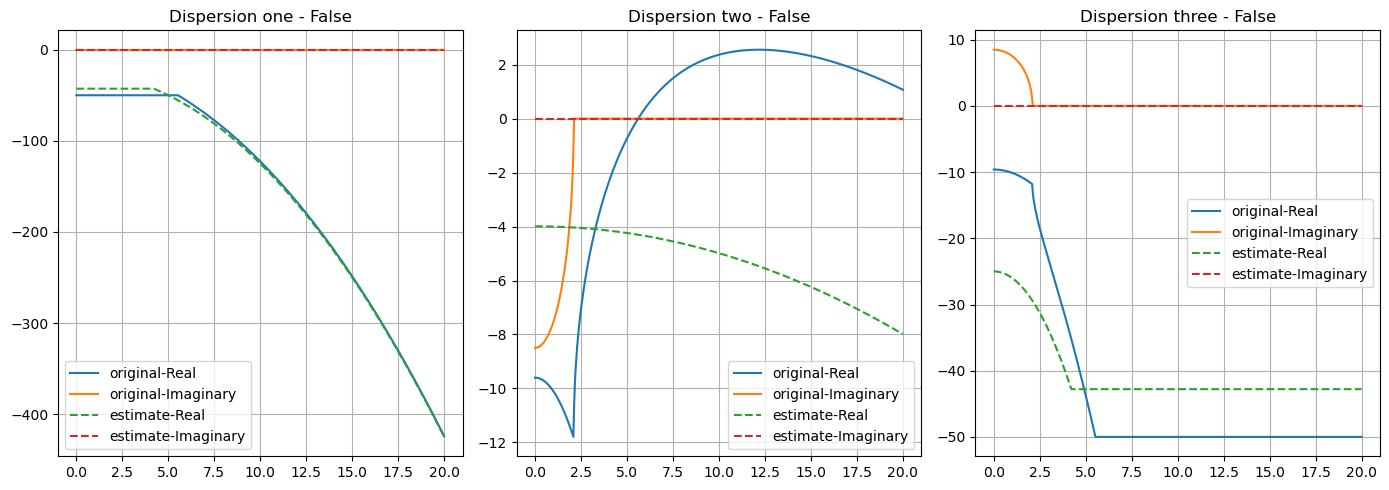

9 : 4876
Original params
b_A:0.100, V_A:20.000, K_AA:1.000, K_AB:0.500, K_AC:0.500
b_B:0.100, V_B:25.000, K_BA:5.000, K_BC:0.500
b_C:20.000, V_C:100.000, K_CB:10.000, K_CC:1.000
Estimated
b_A:0.099, V_A:19.138, K_AA:1.009, K_AB:0.500, K_AC:21.508
b_B:0.064, V_B:24.996, K_BA:5.064, K_BC:19.149
b_C:14.531, V_C:81.984, K_CB:88.014, K_CC:0.385

0.39270666628880996 6.991059765018238 0.20000003027439858
0.39095781403314744 6.859201511971222 0.9287253762621179


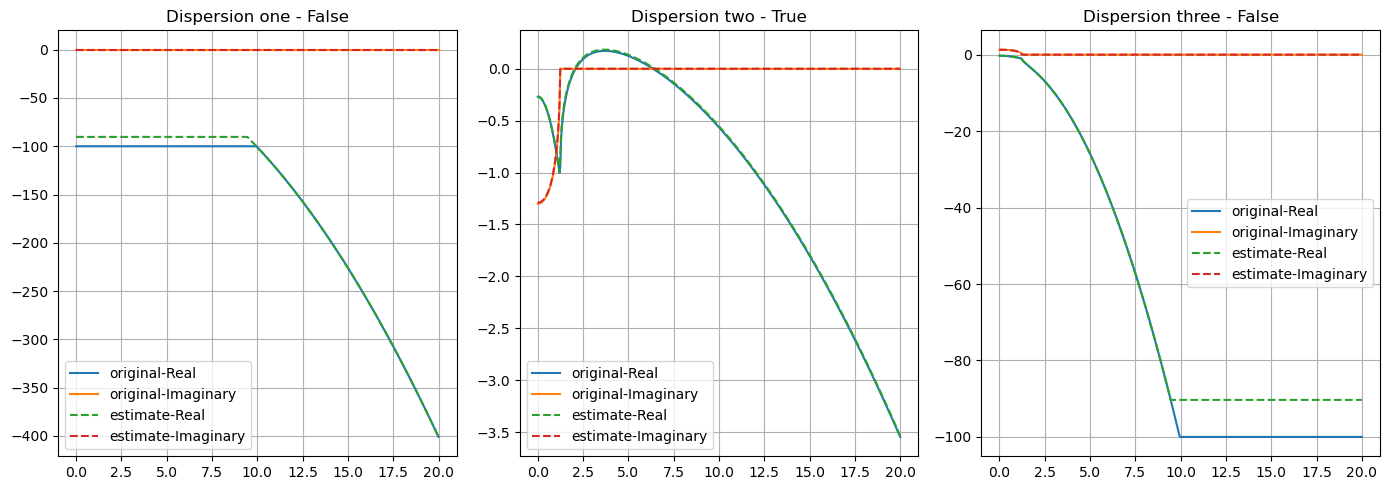

10 : 6898
Original params
b_A:1.000, V_A:100.000, K_AA:10.000, K_AB:5.000, K_AC:5.000
b_B:1.000, V_B:100.000, K_BA:25.000, K_BC:10.000
b_C:5.000, V_C:100.000, K_CB:100.000, K_CC:20.000
Estimated
b_A:1.970, V_A:36.062, K_AA:6.665, K_AB:4.960, K_AC:6.982
b_B:19.788, V_B:49.889, K_BA:21.816, K_BC:2.188
b_C:5.000, V_C:92.663, K_CB:109.871, K_CC:2.853

3.8366266776719438 26.742841297820995 0.500000055623617
4.8675462093625 43.79418283740612 0.499999853241842


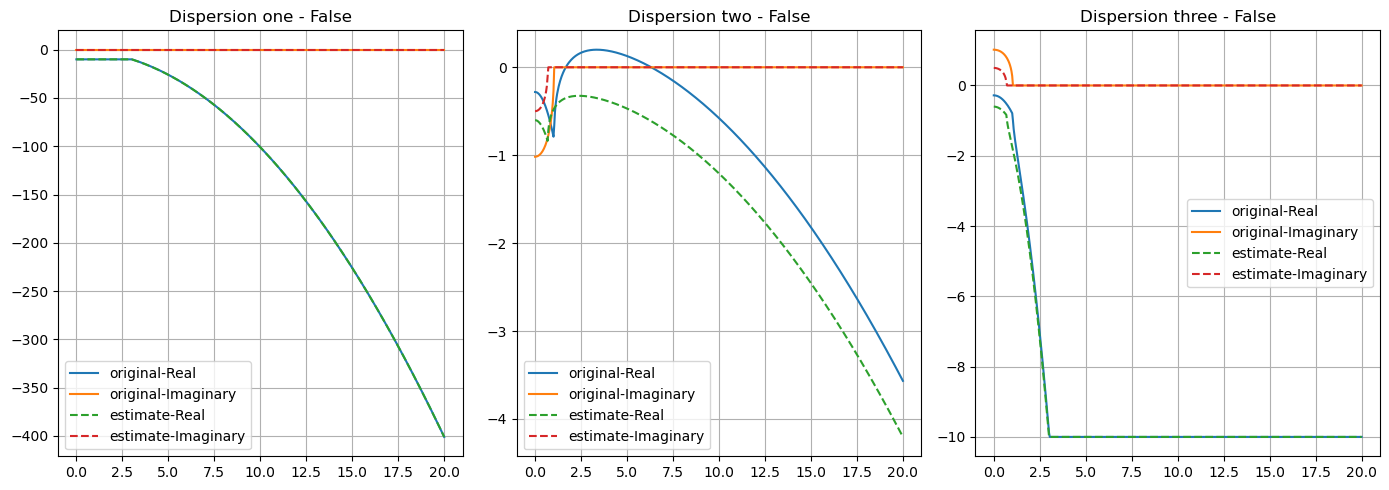

11 : 4867
Original params
b_A:0.100, V_A:20.000, K_AA:1.000, K_AB:1.000, K_AC:1.000
b_B:0.100, V_B:25.000, K_BA:0.500, K_BC:0.500
b_C:1.000, V_C:100.000, K_CB:100.000, K_CC:1.000
Estimated
b_A:0.103, V_A:15.862, K_AA:1.074, K_AB:1.056, K_AC:1.093
b_B:0.101, V_B:30.857, K_BA:0.601, K_BC:0.665
b_C:0.974, V_C:90.833, K_CB:90.000, K_CC:1.049

0.3017604521479371 0.6111810132006893 0.21248274289162794
0.30172569566424656 0.6109356017697767 0.21250114617016153


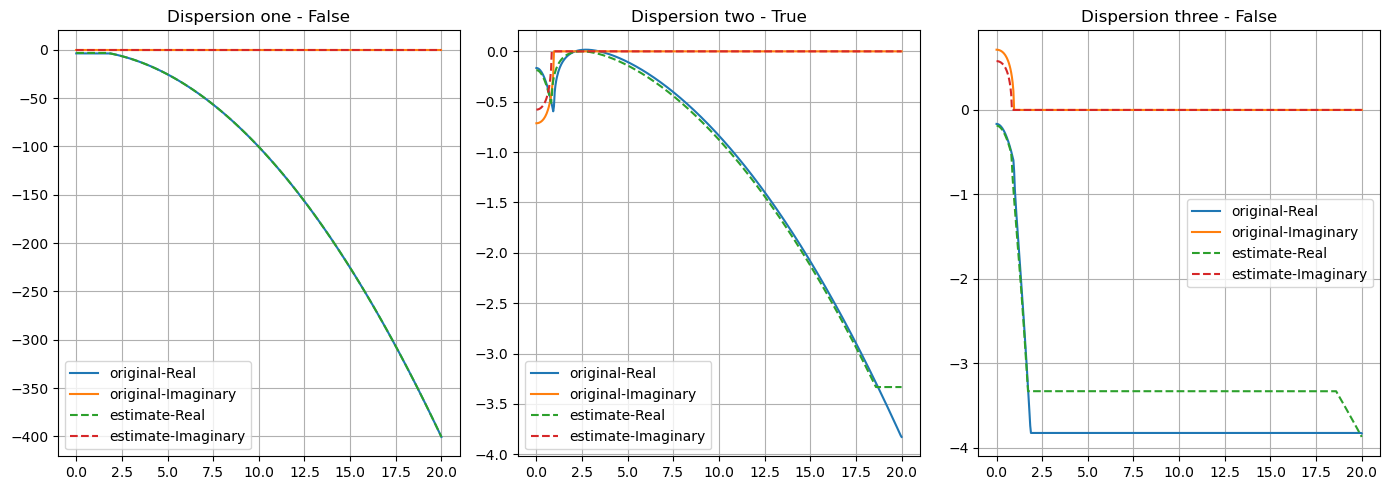

12 : 1861
Original params
b_A:0.001, V_A:20.000, K_AA:1.000, K_AB:1.000, K_AC:10.000
b_B:0.100, V_B:100.000, K_BA:20.000, K_BC:10.000
b_C:20.000, V_C:100.000, K_CB:50.000, K_CC:10.000
Estimated
b_A:0.328, V_A:25.624, K_AA:0.716, K_AB:0.651, K_AC:12.024
b_B:10.813, V_B:40.066, K_BA:11.471, K_BC:11.605
b_C:11.911, V_C:100.820, K_CB:100.063, K_CC:0.000

0.9076146341179111 40.524449192107085 4.00184743320702
0.8648983776336802 41.154973539611824 2.508970338954303


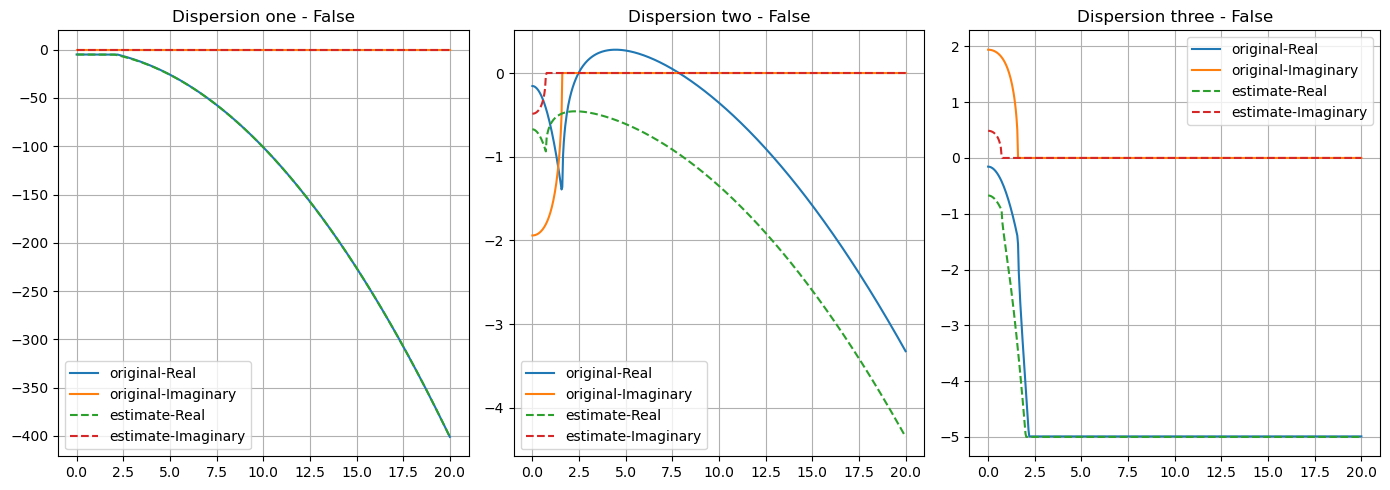

13 : 955
Original params
b_A:0.001, V_A:10.000, K_AA:0.500, K_AB:0.500, K_AC:5.000
b_B:0.100, V_B:25.000, K_BA:5.000, K_BC:10.000
b_C:5.000, V_C:100.000, K_CB:5.000, K_CC:10.000
Estimated
b_A:0.003, V_A:16.997, K_AA:0.492, K_AB:0.499, K_AC:5.581
b_B:0.280, V_B:24.435, K_BA:4.325, K_BC:1.573
b_C:5.003, V_C:90.769, K_CB:84.879, K_CC:2.166

0.45261840783202545 10.127306605917138 1.0009783609134169
0.4534997273426702 10.18945507518066 1.0009609557148396


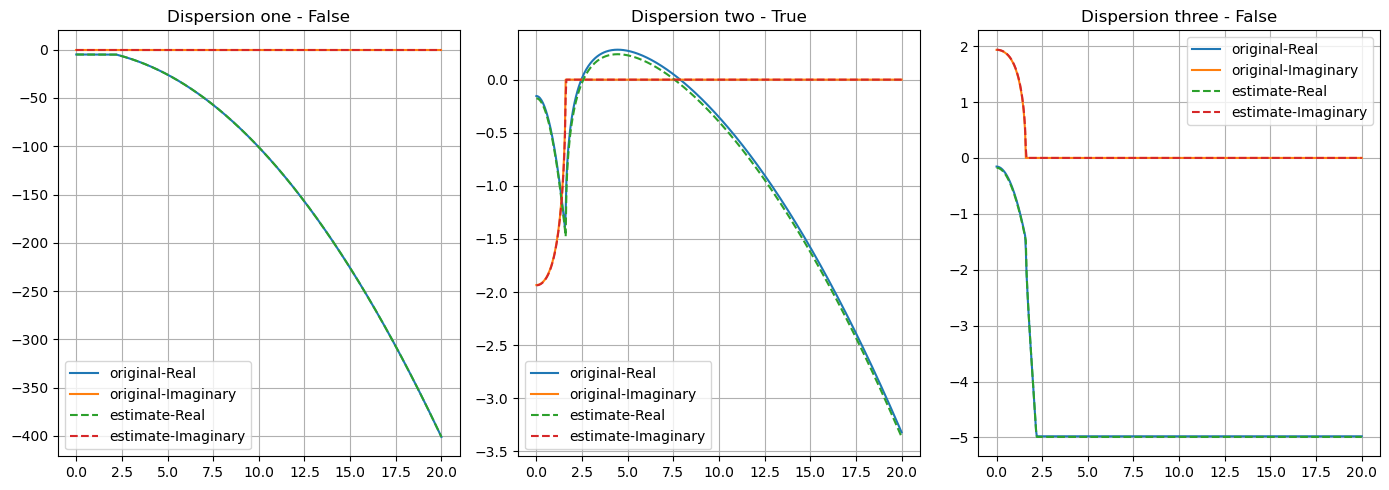

14 : 3007
Original params
b_A:0.001, V_A:50.000, K_AA:5.000, K_AB:5.000, K_AC:0.500
b_B:0.001, V_B:50.000, K_BA:20.000, K_BC:1.000
b_C:0.100, V_C:100.000, K_CB:20.000, K_CC:20.000
Estimated
b_A:5.093, V_A:25.744, K_AA:4.003, K_AB:4.475, K_AC:1.666
b_B:3.818, V_B:39.871, K_BA:11.589, K_BC:0.241
b_C:0.100, V_C:89.973, K_CB:92.133, K_CC:2.470

5.405594886230644 28.869501960655697 0.1
5.461524410059141 31.30252166230106 0.10000000149012342


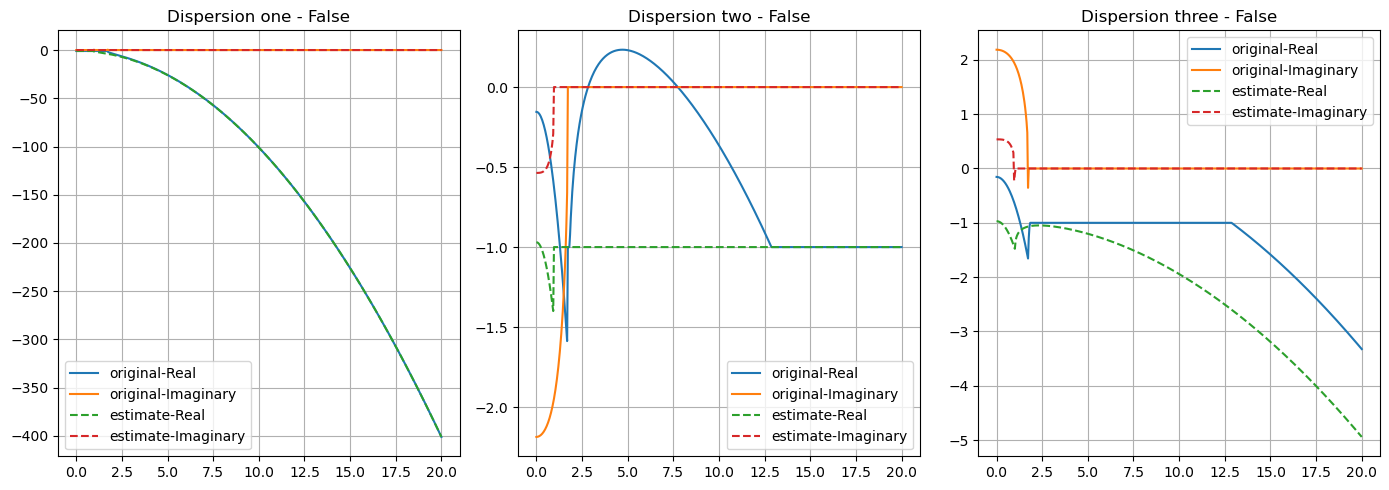

15 : 2495
Original params
b_A:0.001, V_A:50.000, K_AA:1.000, K_AB:1.000, K_AC:5.000
b_B:0.100, V_B:25.000, K_BA:10.000, K_BC:10.000
b_C:0.100, V_C:20.000, K_CB:0.500, K_CC:5.000
Estimated
b_A:0.059, V_A:25.484, K_AA:0.916, K_AB:1.000, K_AC:1.459
b_B:0.103, V_B:24.962, K_BA:11.323, K_BC:0.176
b_C:0.100, V_C:89.884, K_CB:90.088, K_CC:2.531

1.0305914064239918 26.662479483375222 0.10000006198061123
1.0430047816515355 27.250844353495832 0.09999888390332956


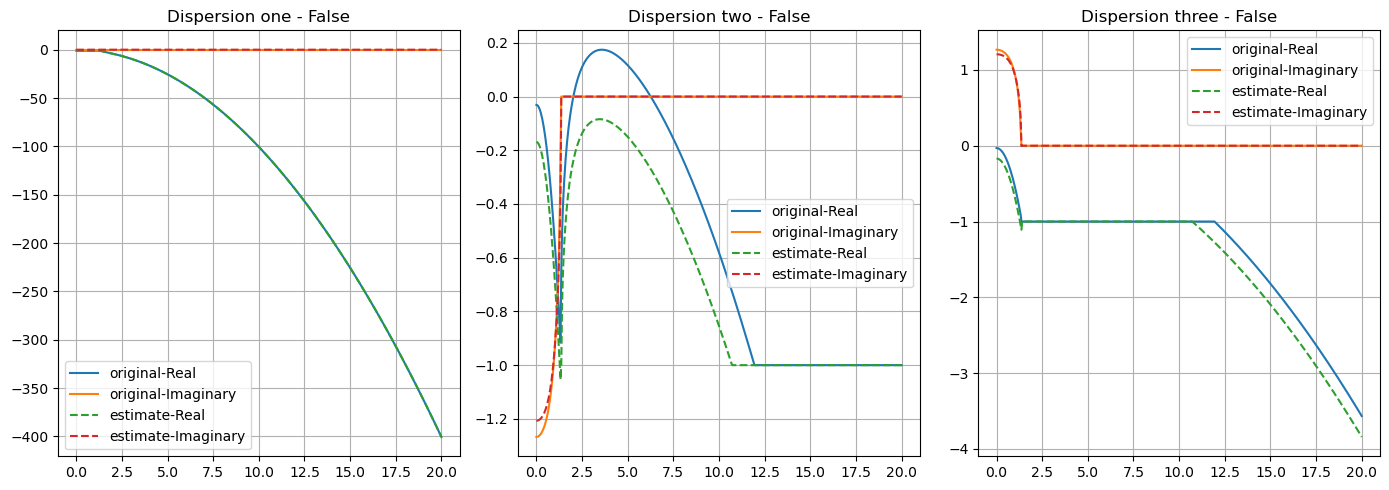

16 : 1692
Original params
b_A:0.001, V_A:10.000, K_AA:5.000, K_AB:5.000, K_AC:0.500
b_B:0.100, V_B:50.000, K_BA:20.000, K_BC:1.000
b_C:0.100, V_C:100.000, K_CB:5.000, K_CC:20.000
Estimated
b_A:0.006, V_A:25.654, K_AA:3.932, K_AB:4.300, K_AC:1.391
b_B:0.000, V_B:36.771, K_BA:11.481, K_BC:0.140
b_C:0.100, V_C:89.754, K_CB:89.717, K_CC:2.566

More than one root
4.322613945338126 18.020053729694457 0.10000000000000012
0.012227291382027161 2.403670232819577e-09 0.10020876876586295


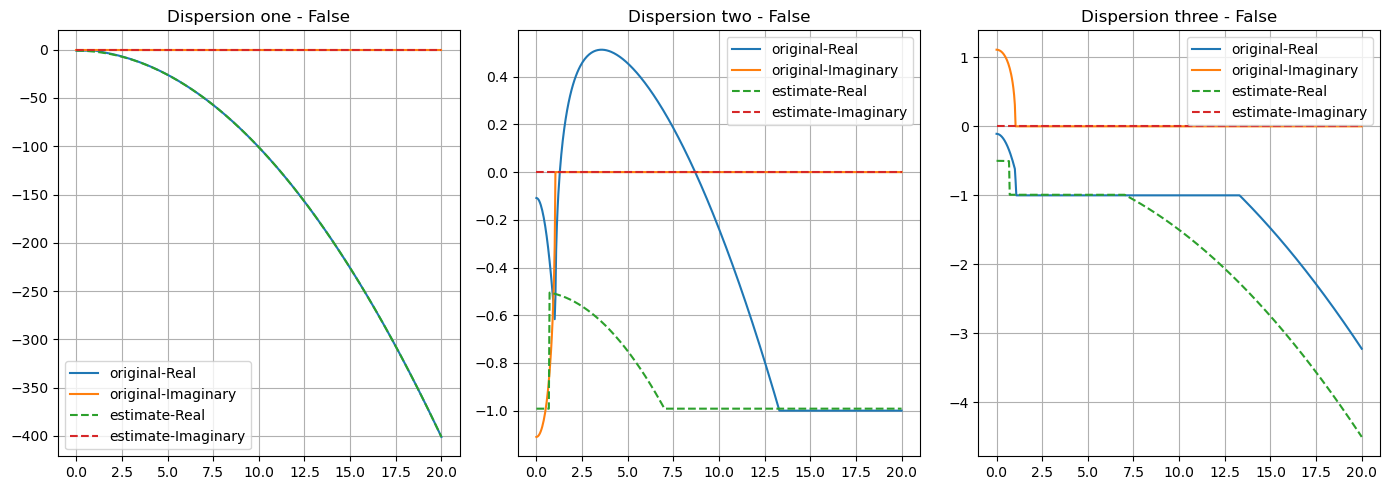

4.322613945338126 18.020053729694457 0.10000000000000012
1.6846950971201706 0.8462999499202111 0.10000005085984831


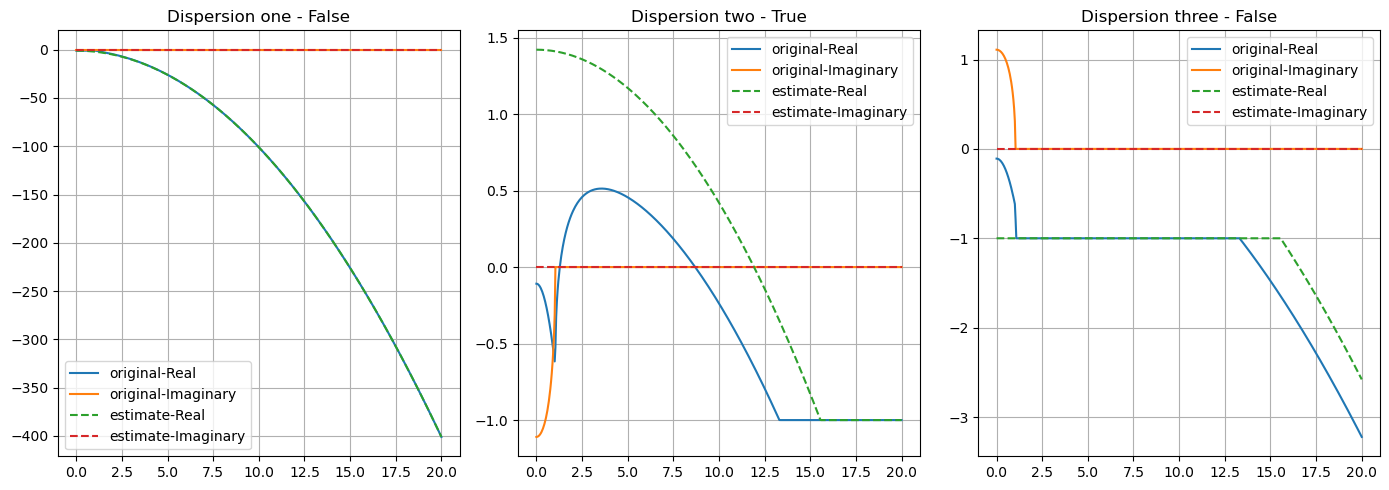

17 : 5868
Original params
b_A:0.100, V_A:50.000, K_AA:1.000, K_AB:1.000, K_AC:5.000
b_B:0.100, V_B:100.000, K_BA:20.000, K_BC:5.000
b_C:1.000, V_C:5.000, K_CB:5.000, K_CC:25.000
Estimated
b_A:1.304, V_A:25.835, K_AA:1.082, K_AB:0.000, K_AC:1.329
b_B:10.875, V_B:40.050, K_BA:11.677, K_BC:0.405
b_C:1.000, V_C:89.507, K_CB:100.046, K_CC:2.511

0.9617182864500563 45.05372370231399 2.000000062035398
1.3548643415865795 50.92432908367469 1.9999922290008414


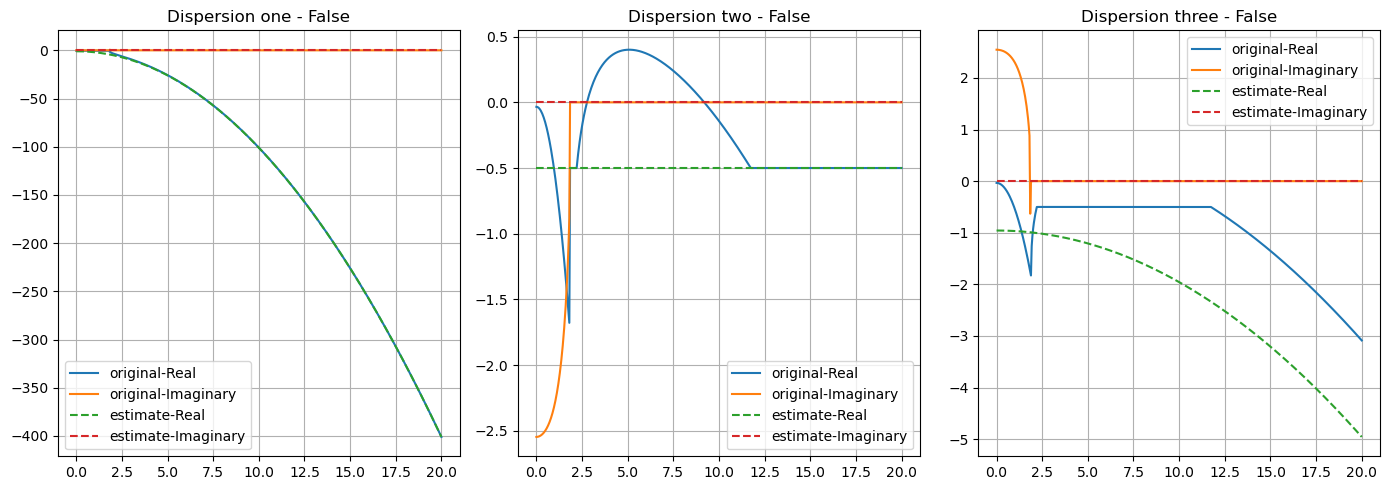

18 : 2656
Original params
b_A:0.001, V_A:20.000, K_AA:0.500, K_AB:0.500, K_AC:5.000
b_B:0.001, V_B:20.000, K_BA:5.000, K_BC:10.000
b_C:1.000, V_C:100.000, K_CB:25.000, K_CC:25.000
Estimated
b_A:0.003, V_A:19.195, K_AA:0.504, K_AB:0.558, K_AC:1.262
b_B:0.000, V_B:22.509, K_BA:5.059, K_BC:0.403
b_C:1.000, V_C:89.520, K_CB:89.176, K_CC:2.472

More than one root
0.5129277360322252 10.511094277439586 0.20000003688601506
0.0029119588675125463 1.6732196327498864e-08 0.20077898485605455


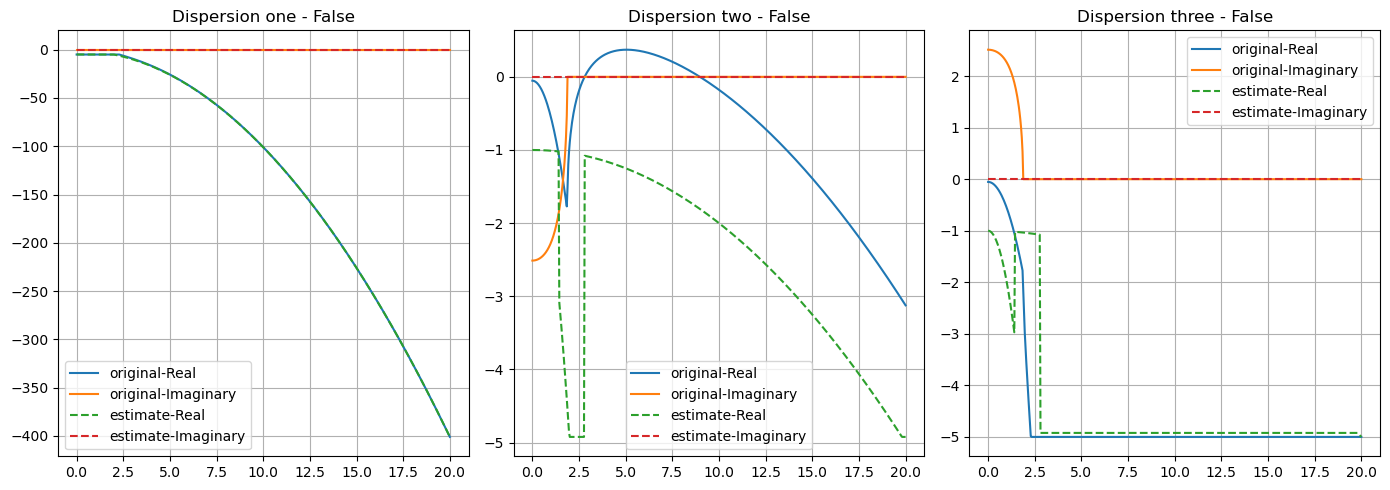

0.5129277360322252 10.511094277439586 0.20000003688601506
0.5420912448521816 10.61694812313316 0.19999998962501422


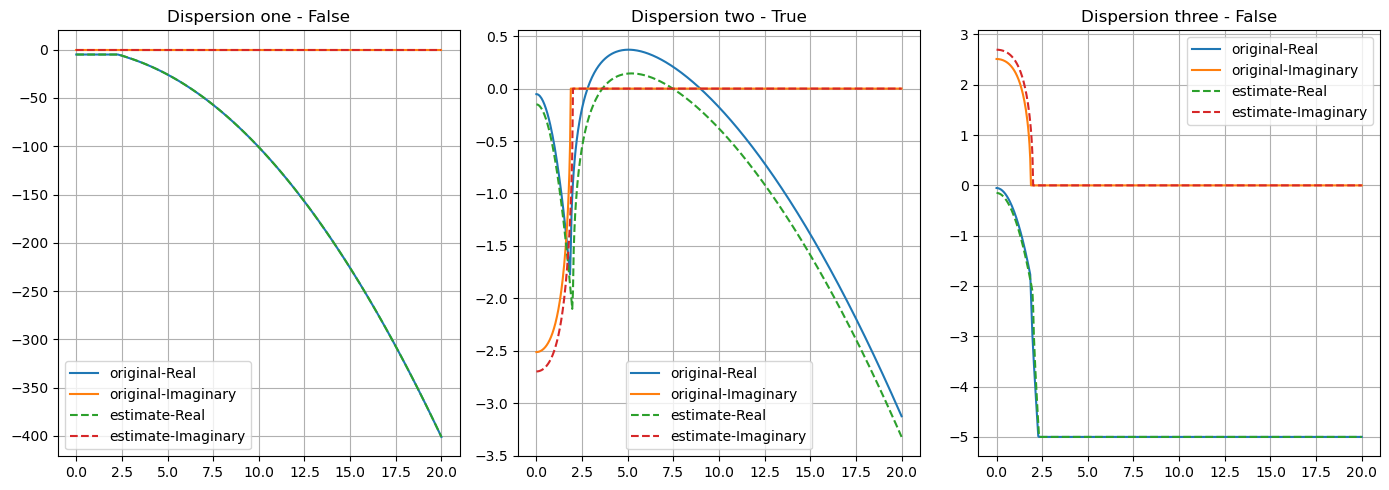

19 : 5512
Original params
b_A:0.100, V_A:20.000, K_AA:5.000, K_AB:5.000, K_AC:50.000
b_B:5.000, V_B:100.000, K_BA:10.000, K_BC:50.000
b_C:20.000, V_C:100.000, K_CB:50.000, K_CC:100.000
Estimated
b_A:5.819, V_A:20.709, K_AA:6.358, K_AB:0.000, K_AC:12.236
b_B:10.960, V_B:39.930, K_BA:6.678, K_BC:5.671
b_C:11.553, V_C:91.597, K_CB:99.928, K_CC:0.000

4.777020557534305 9.855831415927616 20.16480378742803
8.205895851276832 10.169138481748908 18.271948745055845


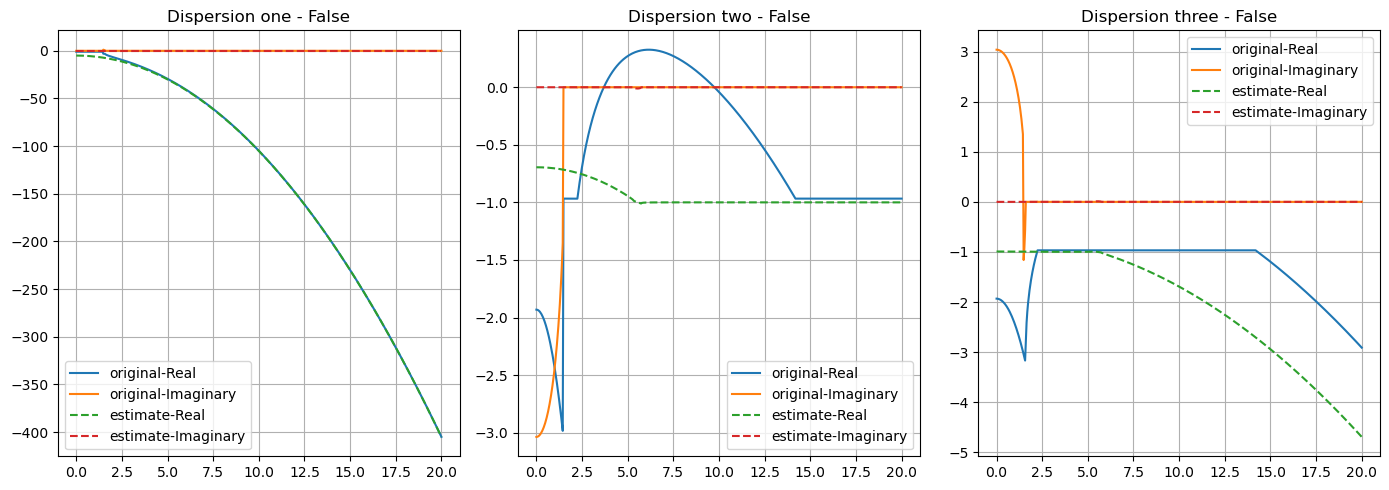

20 : 2326
Original params
b_A:0.001, V_A:25.000, K_AA:5.000, K_AB:5.000, K_AC:5.000
b_B:1.000, V_B:25.000, K_BA:10.000, K_BC:5.000
b_C:10.000, V_C:50.000, K_CB:10.000, K_CC:20.000
Estimated
b_A:0.003, V_A:24.283, K_AA:5.004, K_AB:5.001, K_AC:11.006
b_B:1.002, V_B:24.960, K_BA:10.091, K_BC:3.888
b_C:9.980, V_C:91.526, K_CB:84.985, K_CC:4.454

More than one root
5.162265850766294 14.276116016471667 2.0000069384146077
5.161923494125336 14.273210589244966 1.9996630034876304


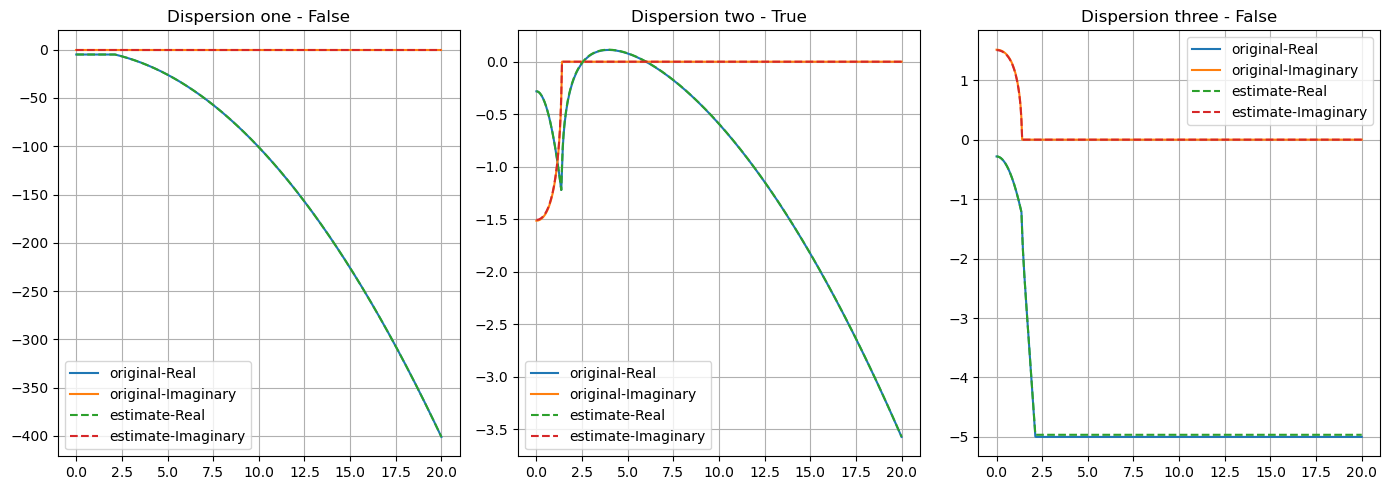

5.162265850766294 14.276116016471667 2.0000069384146077
2.3854731547424657 2.227813102364938 18.426679116901024


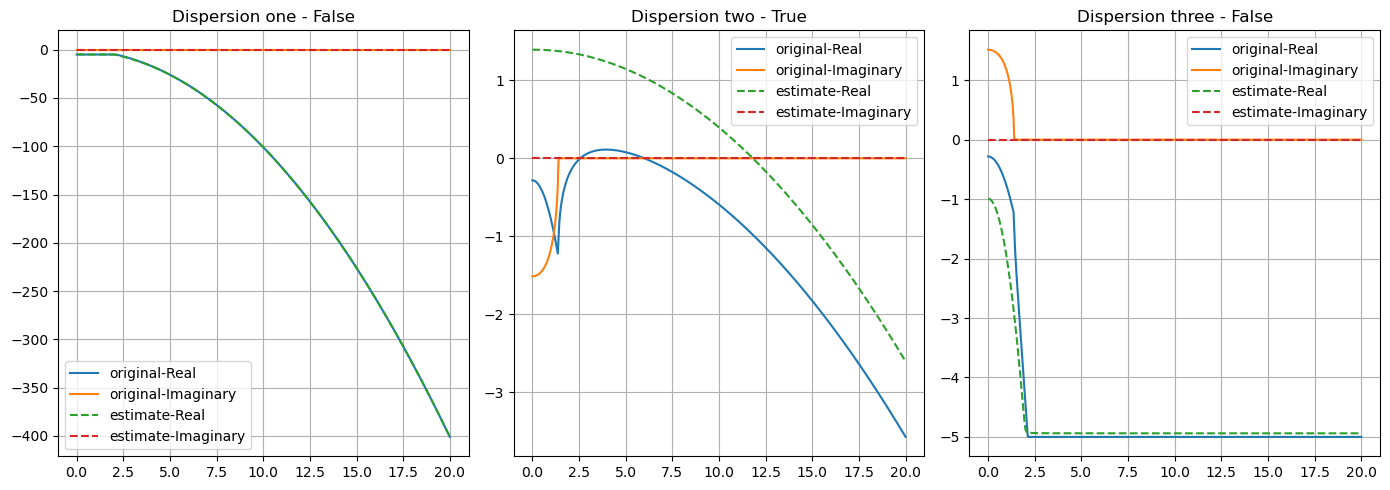

21 : 7271
Original params
b_A:10.000, V_A:50.000, K_AA:0.500, K_AB:0.500, K_AC:1.000
b_B:10.000, V_B:50.000, K_BA:0.500, K_BC:1.000
b_C:20.000, V_C:100.000, K_CB:50.000, K_CC:100.000
Estimated
b_A:9.599, V_A:25.001, K_AA:0.426, K_AB:0.438, K_AC:9.603
b_B:9.149, V_B:40.122, K_BA:9.961, K_BC:5.154
b_C:3.002, V_C:91.350, K_CB:98.560, K_CC:0.578

More than one root
0.2864512610838853 0.2972501661597517 0.4000000005046361
0.23359572085413718 0.24287208063218174 0.06025112889679001


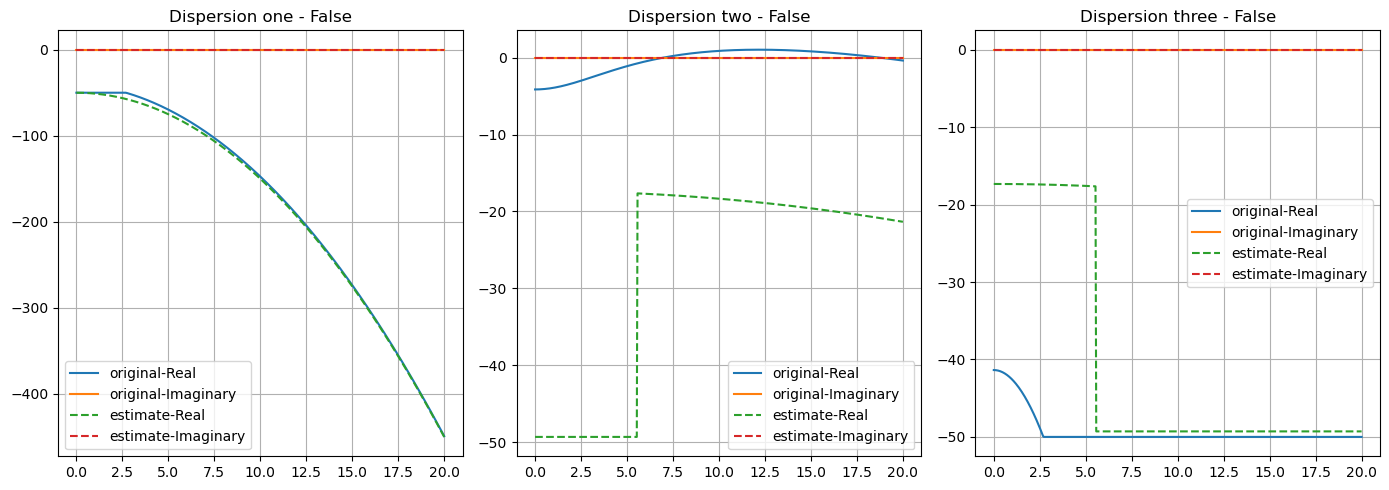

0.2864512610838853 0.2972501661597517 0.4000000005046361
0.5790656065790001 0.7870777726438537 1.869431000223962


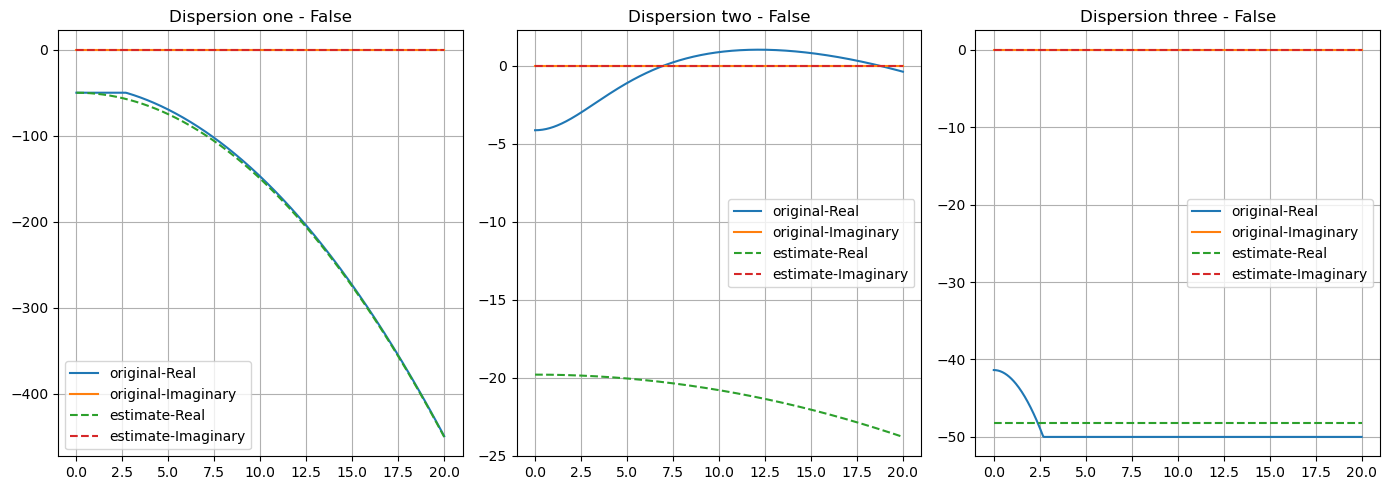

22 : 3787
Original params
b_A:0.001, V_A:10.000, K_AA:0.001, K_AB:0.001, K_AC:5.000
b_B:0.001, V_B:10.000, K_BA:0.100, K_BC:5.000
b_C:20.000, V_C:100.000, K_CB:50.000, K_CC:50.000
Estimated
b_A:0.010, V_A:15.000, K_AA:2.081, K_AB:0.002, K_AC:1.960
b_B:0.705, V_B:23.870, K_BA:0.990, K_BC:5.430
b_C:1.964, V_C:89.191, K_CB:83.081, K_CC:2.819

0.0009834408237113595 0.48340715537086865 2.0000255990085156
0.0009538964369061283 0.28545010503807455 0.19661930280911813


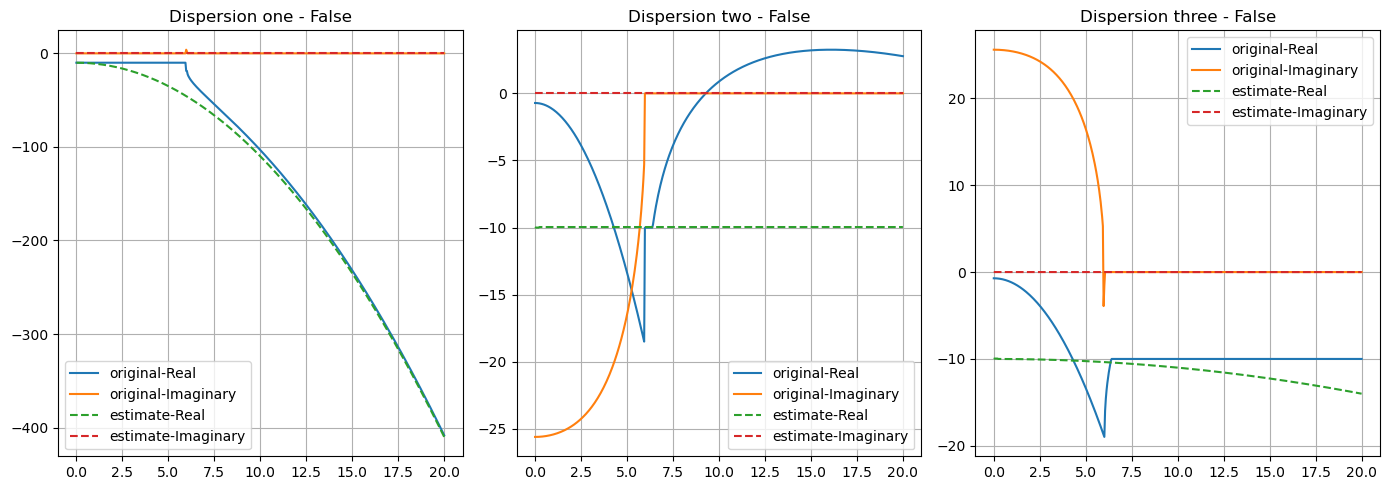

23 : 4046
Original params
b_A:0.100, V_A:0.500, K_AA:0.500, K_AB:0.500, K_AC:5.000
b_B:0.100, V_B:25.000, K_BA:5.000, K_BC:5.000
b_C:10.000, V_C:100.000, K_CB:50.000, K_CC:50.000
Estimated
b_A:0.107, V_A:14.549, K_AA:1.176, K_AB:0.511, K_AC:9.965
b_B:0.166, V_B:26.381, K_BA:3.915, K_BC:8.646
b_C:9.593, V_C:84.503, K_CB:88.781, K_CC:7.546

0.305563223692677 3.160236496600136 2.0000441568104628
0.30587445523174817 3.167997945249658 2.000151476777739


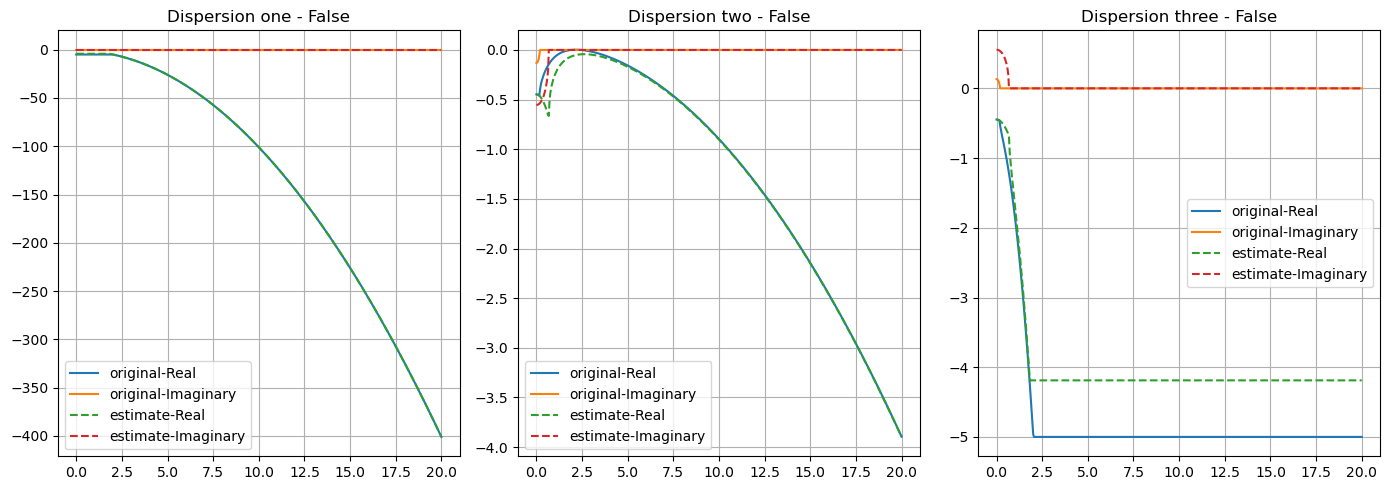

In [17]:
Ls = [50, 1, 10, 10, 10, 10, 10, 10, 1, 10, 10, 10, 50, 10, 10, 1, 1, 10, 1, 10, 1, 1, 50]
for i, L in zip(range(len(Ls)), Ls):
    plot_dispersion(i)

In [85]:
import inspect
lines = inspect.getsource(J_jac_func)
print(lines)


def _lambdifygenerated(n, b_A, mu_A, V_A, K_AA, K_AB, K_AC, b_B, mu_B, V_B, K_BA, K_BC, b_C, mu_C, V_C, K_CB, K_CC, A, B, C):
    return array([[-mu_A + V_A*n*(K_AA/A)**n/(A*((K_AA/A)**n + 1)**2*((B/K_BA)**n + 1)), -V_A*n*(B/K_BA)**n/(B*((K_AA/A)**n + 1)*((B/K_BA)**n + 1)**2), 0], [V_B*n*(K_AB/A)**n/(A*((K_AB/A)**n + 1)**2*((C/K_CB)**n + 1)), -mu_B, -V_B*n*(C/K_CB)**n/(C*((K_AB/A)**n + 1)*((C/K_CB)**n + 1)**2)], [-V_C*n*(A/K_AC)**n/(A*((A/K_AC)**n + 1)**2*((B/K_BC)**n + 1)*((K_CC/C)**n + 1)), -V_C*n*(B/K_BC)**n/(B*((A/K_AC)**n + 1)*((B/K_BC)**n + 1)**2*((K_CC/C)**n + 1)), -mu_C + V_C*n*(K_CC/C)**n/(C*((A/K_AC)**n + 1)*((B/K_BC)**n + 1)*((K_CC/C)**n + 1)**2)]])

